In [4]:
import os
import json
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pymongo
from tqdm import tqdm
from scipy import stats
import math
import numpy as np

In [5]:
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
db = myclient["imdb"]
imdb = db['imdb_cleaned']

In [6]:
num_movies = imdb.count_documents({})
num_movies

8181

In [28]:
budget_arr = []
revenue_arr = []

for movie in imdb.find():
    budget = movie['cleaned_Budget']
    revenue = movie['cleaned_Revenue']

    budget_arr.append(budget)
    revenue_arr.append(revenue)

In [77]:
def plotDistribution(revenue_arr, budget_arr):
    revenue_arr = np.array(revenue_arr)
    budget_arr = np.array(budget_arr)
    million = 1000000
    margin = 50*million
    # mx = max(revenue_arr.max(), budget_arr.max())
    mx = 499*million

    current = 0

    revenue_dict = {}
    budget_dict = {}
    while (current <= mx):
        revenue_dict[current] = None
        budget_dict[current] = None
        current += margin

    for rev in revenue_arr:
        if(rev > mx):
            continue
        rng = (rev//margin)*margin
        if(revenue_dict[rng] == None):
            revenue_dict[rng] = 0
        revenue_dict[rng] += 1

    for bud in budget_arr:
        if(bud > mx):
            continue
        rng = (bud//margin)*margin
        # print(bud, rng)
        if(budget_dict[rng] == None):
            budget_dict[rng] = 0
        budget_dict[rng] += 1

    label_arr = []
    revenue_dist = []
    budget_dist = []

    for key in revenue_dict:
        label_arr.append('{}M - {}M'.format(key//million, (key+margin)//million))
        revenue_dist.append(revenue_dict[key])
        budget_dist.append(budget_dict[key])

    fig = make_subplots()
    fig.add_trace(
        go.Scatter(
            x=label_arr, 
            y=revenue_dist, 
            text=revenue_dist,
            name="Revenue",
            mode='lines + markers',
            line_color='rgba(72, 61, 139, .7)',
            line_shape='spline'
        ),
    )
    fig.add_trace(
        go.Scatter(
            x=label_arr, 
            y=budget_dist, 
            name="Budget",
            mode='lines + markers',
            line_color='rgba(139, 0, 0, .5)',
            line_shape='spline'
        ),
    )
    fig.update_yaxes(rangemode="tozero")
    fig.update_layout(legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ))
    # fig = go.Figure(data=[
    #     go.Bar(name='Revenue',x=label_arr, y=revenue_dist, marker_color="steelblue", text=revenue_dist, textposition='outside'),
    #     go.Bar(name='Budget', x=label_arr, y=budget_dist, marker_color='firebrick', text=budget_dist, textposition='outside')
    # ])

    fig.update_layout(
        height=600, 
        width=800,
    )
    return fig

In [78]:
fig = plotDistribution(revenue_arr, budget_arr)
fig.update_layout(
     margin=dict(l=10, r=10, t=10, b=10),
     # paper_bgcolor="LightSteelBlue",
)

fig.update_layout(
    font_family="Times New Roman",
    font_color="black",
    title_font_family="Times New Roman",
    title_font_color="red",
    legend_title_font_color="green",
)

fig.update_layout(
    # title="Plot Title",
    xaxis_title="USD",
    yaxis_title="Count",
    # legend_title="Legend Title",
)

fig.update_layout(font=dict(size=18))

In [89]:
def checkPercentile(np_arr, val):
    lo = 0
    hi = 100
    ret = lo
    th = .001
    while(hi-lo > th):
        mid = (lo + hi)/2
        if(np.percentile(np_arr, mid) <= val):
            ret = lo
            lo = mid
        else:
            hi = mid
    return ret

In [92]:
revenue_arr = np.array(revenue_arr)
revenue_arr.mean(), np.median(revenue_arr), np.percentile(revenue_arr, 75.23), checkPercentile(revenue_arr, revenue_arr.mean())

(100747045.3002078, 25762274.0, 100639652.272, 75.23651123046875)

In [93]:
budget_arr = np.array(budget_arr)
budget_arr.mean(), np.median(budget_arr), np.percentile(budget_arr, 75.23), checkPercentile(budget_arr, budget_arr.mean())

(36986670.458745874, 21566954.0, 47323056.392000034, 67.2088623046875)

In [8]:
budget_arr = np.array(budget_arr)
print(budget_arr.max())
budget_arr = (budget_arr-budget_arr.min())/(budget_arr.max()-budget_arr.min())

revenue_arr = np.array(revenue_arr)
revenue_arr = (revenue_arr-revenue_arr.min())/(revenue_arr.max()-revenue_arr.min())

374469716


# Linear Regression

In [9]:
from scipy.stats import spearmanr
from scipy.stats import pearsonr

In [10]:
spearmanr(budget_arr, revenue_arr)

SpearmanrResult(correlation=0.7434469021284774, pvalue=0.0)

In [11]:
pearsonr(budget_arr, revenue_arr)

(0.6635874172113063, 0.0)

In [12]:
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [13]:
budget_x = sm.add_constant(budget_arr)
model = sm.OLS(revenue_arr, budget_x)
results = model.fit()

In [14]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                     6435.
Date:                Sun, 30 May 2021   Prob (F-statistic):               0.00
Time:                        21:08:43   Log-Likelihood:                 13887.
No. Observations:                8181   AIC:                        -2.777e+04
Df Residuals:                    8179   BIC:                        -2.776e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0036      0.001     -5.666      0.000      -0.005      -0.002
x1             0.3235      0.004     80.221      0.000       0.316       0.331
==============================================================================
Omnibus:                     9241.878   Durbin-Watson:                   1.726
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1647354.689
Skew:                           5.605   Prob(JB):                         0.00
Kurtosis:                      71.608   Cond. No.                         8.31
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
from statsmodels.stats.outliers_influence import summary_table

In [16]:
def plot_regression_line(results, xrr, yrr):

    st, data, ss2 = summary_table(results, alpha=0.05)

    fittedvalues = data[:, 2]
    predict_mean_se  = data[:, 3]
    predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
    predict_ci_low, predict_ci_upp = data[:, 6:8].T

    fig = make_subplots()
    fig.add_trace(
        go.Scatter(
            x=xrr, 
            y=yrr, 
            name="Data points",
            mode='markers',
            line_color='rgba(153, 153, 255, .6)'
        ),
    )
    fig.add_trace(
        go.Scatter(
            x=xrr, 
            y=fittedvalues, 
            name="Regression line",
            # mode='lines',
            # line_color='green'
            line=dict(color='green', width=3)
        ),
    )
    fig.add_trace(
        go.Scatter(
            x=xrr, 
            y=predict_ci_low, 
            name="95% prediction band",
            line=dict(color='rgba(153, 0, 51, .5)', width=1, dash='dot')
        ),
    )
    fig.add_trace(
        go.Scatter(
            x=xrr, 
            y=predict_ci_upp, 
            line=dict(color='rgba(153, 0, 51, .5)', width=1, dash='dot'),
            showlegend=False
        ),
    )

    fig.add_trace(
        go.Scatter(
            x=xrr, 
            y=predict_mean_ci_low, 
            name="95% prediction region",
            mode='lines',
            line=dict(color='rgba(0, 153, 51, .5)', width=1, dash='dot'),
        ),
    )
    fig.add_trace(
        go.Scatter(
            x=xrr, 
            y=predict_mean_ci_upp, 
            line=dict(color='rgba(0, 153, 51, .5)', width=1, dash='dot'),
            showlegend=False
        ),
    )

    fig.update_layout(legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ))
    fig.update_layout(
        height=600, 
        width=800,
    )
    # fig.update_layout(
    #     # margin=dict(l=10, r=10, t=10, b=10),
    #     paper_bgcolor="LightSteelBlue",
    # )
    fig.update_layout(
        # title="Plot Title",
        xaxis_title="Budget",
        yaxis_title="Revenue",
        # legend_title="Legend Title",
    )
    
    return fig

In [17]:
fig = plot_regression_line(results, budget_arr, revenue_arr)
fig.update_layout(
     margin=dict(l=10, r=10, t=10, b=10),
     # paper_bgcolor="LightSteelBlue",
)

fig.update_layout(
    font_family="Times New Roman",
    font_color="black",
    title_font_family="Times New Roman",
    title_font_color="red",
    legend_title_font_color="green",
)
fig.update_layout(font=dict(size=18))
fig.show()

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

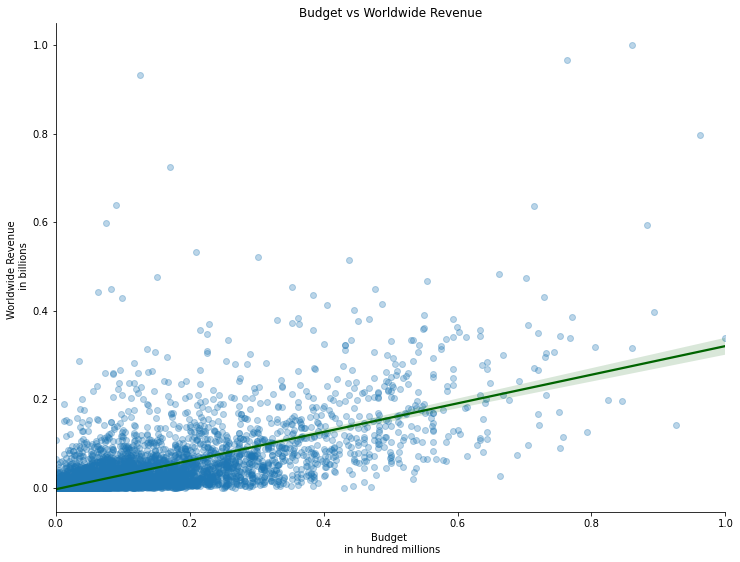

In [24]:
plt.figure(figsize=(12, 9))
sns.regplot(x = budget_arr, y = revenue_arr, scatter_kws={'alpha':0.3}, line_kws={"color": "darkgreen"})
plt.title('Budget vs Worldwide Revenue')          # Set title.
plt.xlabel("Budget \n in hundred millions")       # Set x-axis label.
plt.ylabel('Worldwide Revenue \n in billions')    # Set y-axis label.
sns.despine()

In [47]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
xxrr = budget_arr.reshape(budget_arr.shape[0],1)
regressor.fit(xxrr, revenue_arr)

LinearRegression()

In [48]:
regressor.coef_

array([0.32353461])

In [49]:
regressor.intercept_

-0.0035781000361154863

In [26]:
plotDistribution(revenue_arr, budget_arr)